In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob2 import glob  

# import pandas_profiling

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from numba import jit

import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

test_num = 23

In [8]:
train_list = glob('./aT_data/data/train/*.csv')
train_list

['./aT_data/data/train/train_4.csv',
 './aT_data/data/train/train_15.csv',
 './aT_data/data/train/train_29.csv',
 './aT_data/data/train/train_28.csv',
 './aT_data/data/train/train_14.csv',
 './aT_data/data/train/train_5.csv',
 './aT_data/data/train/train_7.csv',
 './aT_data/data/train/train_16.csv',
 './aT_data/data/train/train_17.csv',
 './aT_data/data/train/train_6.csv',
 './aT_data/data/train/train_2.csv',
 './aT_data/data/train/train_13.csv',
 './aT_data/data/train/train_12.csv',
 './aT_data/data/train/train_3.csv',
 './aT_data/data/train/train_1.csv',
 './aT_data/data/train/train_10.csv',
 './aT_data/data/train/train_11.csv',
 './aT_data/data/train/train_0.csv',
 './aT_data/data/train/train_34.csv',
 './aT_data/data/train/train_20.csv',
 './aT_data/data/train/train_21.csv',
 './aT_data/data/train/train_35.csv',
 './aT_data/data/train/train_23.csv',
 './aT_data/data/train/train_36.csv',
 './aT_data/data/train/train_22.csv',
 './aT_data/data/train/train_26.csv',
 './aT_data/data/tra

In [9]:
df = pd.read_csv(train_list[0])

In [10]:
def feature_select(df):
       #시간 코사인 인코딩
       if df['datadate'].all() == 0:
         df['datadate'] = 20180520
       df['datetime'] = pd.to_datetime(df['datadate'], format="%Y%m%d")
       df['cos_time'] = np.cos(2*np.pi*df['datetime'].dt.dayofyear/365)
       df = df.set_index('datetime')

       # 결측치
       df = df.replace(' ', np.nan)

       # 주산지 초기온도, 최대온도, 최저온도, 평균온도, 강수량, 습도
       df['주산지_초기온도'] = (df['주산지_0_초기온도(℃)'] + df['주산지_1_초기온도(℃)'] + df['주산지_2_초기온도(℃)'])/3
       df['주산지_최대온도'] = (df['주산지_0_최대온도(℃)'] + df['주산지_1_최대온도(℃)'] + df['주산지_2_최대온도(℃)'])/3
       df['주산지_최저온도'] = (df['주산지_0_최저온도(℃)'] + df['주산지_1_최저온도(℃)'] + df['주산지_2_최저온도(℃)'])/3
       df['주산지_평균온도'] = (df['주산지_0_평균온도(℃)'] + df['주산지_1_평균온도(℃)'] + df['주산지_2_평균온도(℃)'])/3
       df['주산지_강수량'] = (df['주산지_0_강수량(ml)'] + df['주산지_1_강수량(ml)'] + df['주산지_2_강수량(ml)'])/3

       # 필요한 컬럼 선택
       
       market_cols = ['단가(원)', '거래량'] # '경매건수',, '거래대금(원)'

       market_code_cols = [] # '도매시장코드', '도매법인코드', '산지코드 '

       market_statistics_cols = [ '일자별_도매가격_평균(원)', '해당일자_전체거래물량(kg)'
                                 ] 
       # '상위가격 평균가(원)',  '하위가격 평균가(원)',
       # '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)', '일자별_소매가격_최소( 원)',
       #  '하위가격 거래물량(kg)', '상위가격 거래물량(kg)',
       #  '일자별_도매가격_최대(원)','일자별_도매가격_최소(원)', , 
       
       export_cols = [] # '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)', '무역수지(달러)'
       
       date_cols = ['cos_time'] 
       # '일자구분_중순', '일자구분_초순', '일자구분_하순', '월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월','월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월', 'datetime'

       weather_cols = ['주산지_평균온도', '주산지_강수량'] 
       # '주산지_초기온도', '주산지_최대온도', '주산지_최저온도', 
      #  '주산지_0_초기온도(℃)', '주산지_1_초기온도(℃)', '주산지_2_초기온도(℃)',
      #  '주산지_0_최대온도(℃)', '주산지_1_최대온도(℃)', '주산지_2_최대온도(℃)',
      #  '주산지_0_최저온도(℃)', '주산지_1_최저온도(℃)', '주산지_2_최저온도(℃)',
      #  '주산지_0_평균온도(℃)', '주산지_1_평균온도(℃)', '주산지_2_평균온도(℃)',
      #  '주산지_0_강수량(ml)', '주산지_1_강수량(ml)', '주산지_2_강수량(ml)',
      #  '주산지_0_습도(%)', '주산지_1_습도(%)', '주산지_2_습도(%)'

       selected_columns = ['해당일자_전체평균가격(원)']  + market_cols + market_code_cols + market_statistics_cols + export_cols +  date_cols + weather_cols # train 에서 사용하지 않는 열
       df = df[[c for c in df.columns if c in selected_columns]]

       return df

In [11]:
# def feature_scale(df):
#     scaler = RobustScaler()
#     scale_columns = [c for c in df.columns if c not in ['datadate', 'cos_time']]
    
#     df[scale_columns] = scaler.fit_transform(df[scale_columns])

#     return df

In [12]:
def feature_na(df):
    df = df.interpolate()
    df = df.fillna(method = 'bfill')

    return df

In [13]:
df = feature_select(df)
# df = feature_scale(df)
df = feature_na(df)
df

,단가(원),거래량,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),일자별_도매가격_평균(원),cos_time,주산지_평균온도,주산지_강수량
datetime,,,,,,,,
2013-01-01,1298.70,435.0,1587.314723,116539.0,38800.0,0.999852,4.466667,0.000000
2013-01-02,1298.70,435.0,1587.314723,116539.0,38800.0,0.999407,7.466667,0.000000
2013-01-03,929.07,1005.0,1731.765036,812663.0,38800.0,0.998667,4.633333,0.000000
2013-01-04,960.96,360.0,1433.421743,282245.0,38800.0,0.997630,5.000000,0.000000
2013-01-05,720.72,5400.0,1549.518789,347766.0,39800.0,0.996298,4.166667,2.666667
...,...,...,...,...,...,...,...,...
2016-12-27,3560.10,780.0,3600.811574,151312.0,71525.0,0.998667,4.833333,4.466667
2016-12-28,3663.66,1125.0,3666.548045,237547.0,71460.0,0.999407,5.966667,6.333333
2016-12-29,2507.49,30.0,3652.588226,118475.0,71460.0,0.999852,2.900000,0.966667


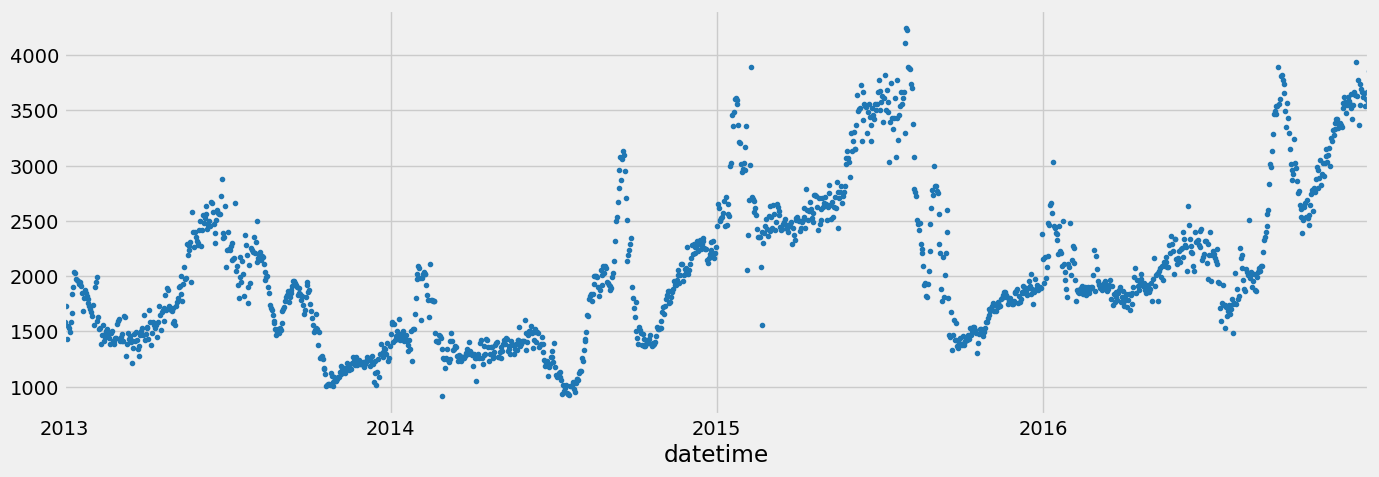

In [14]:
df['해당일자_전체평균가격(원)'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='')
plt.show()

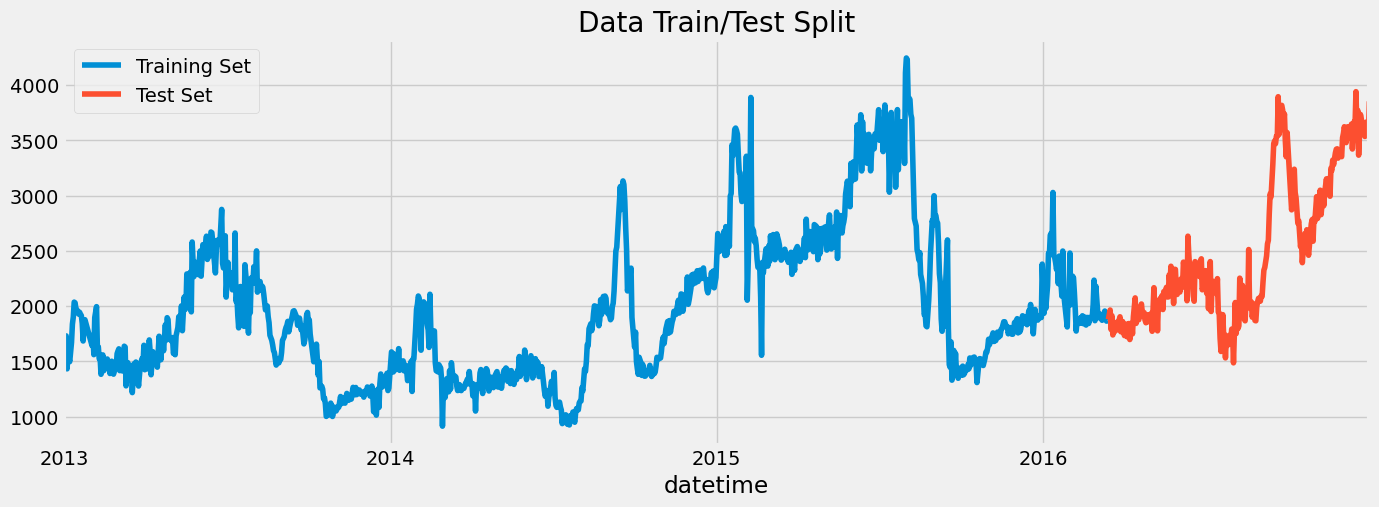

In [15]:
cut = int(len(df)*0.8)

train = df.iloc[:cut]
test = df.iloc[cut:]

fig, ax = plt.subplots(figsize=(15, 5))
train['해당일자_전체평균가격(원)'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['해당일자_전체평균가격(원)'].plot(ax=ax, label='Test Set')
# ax.axvline(, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

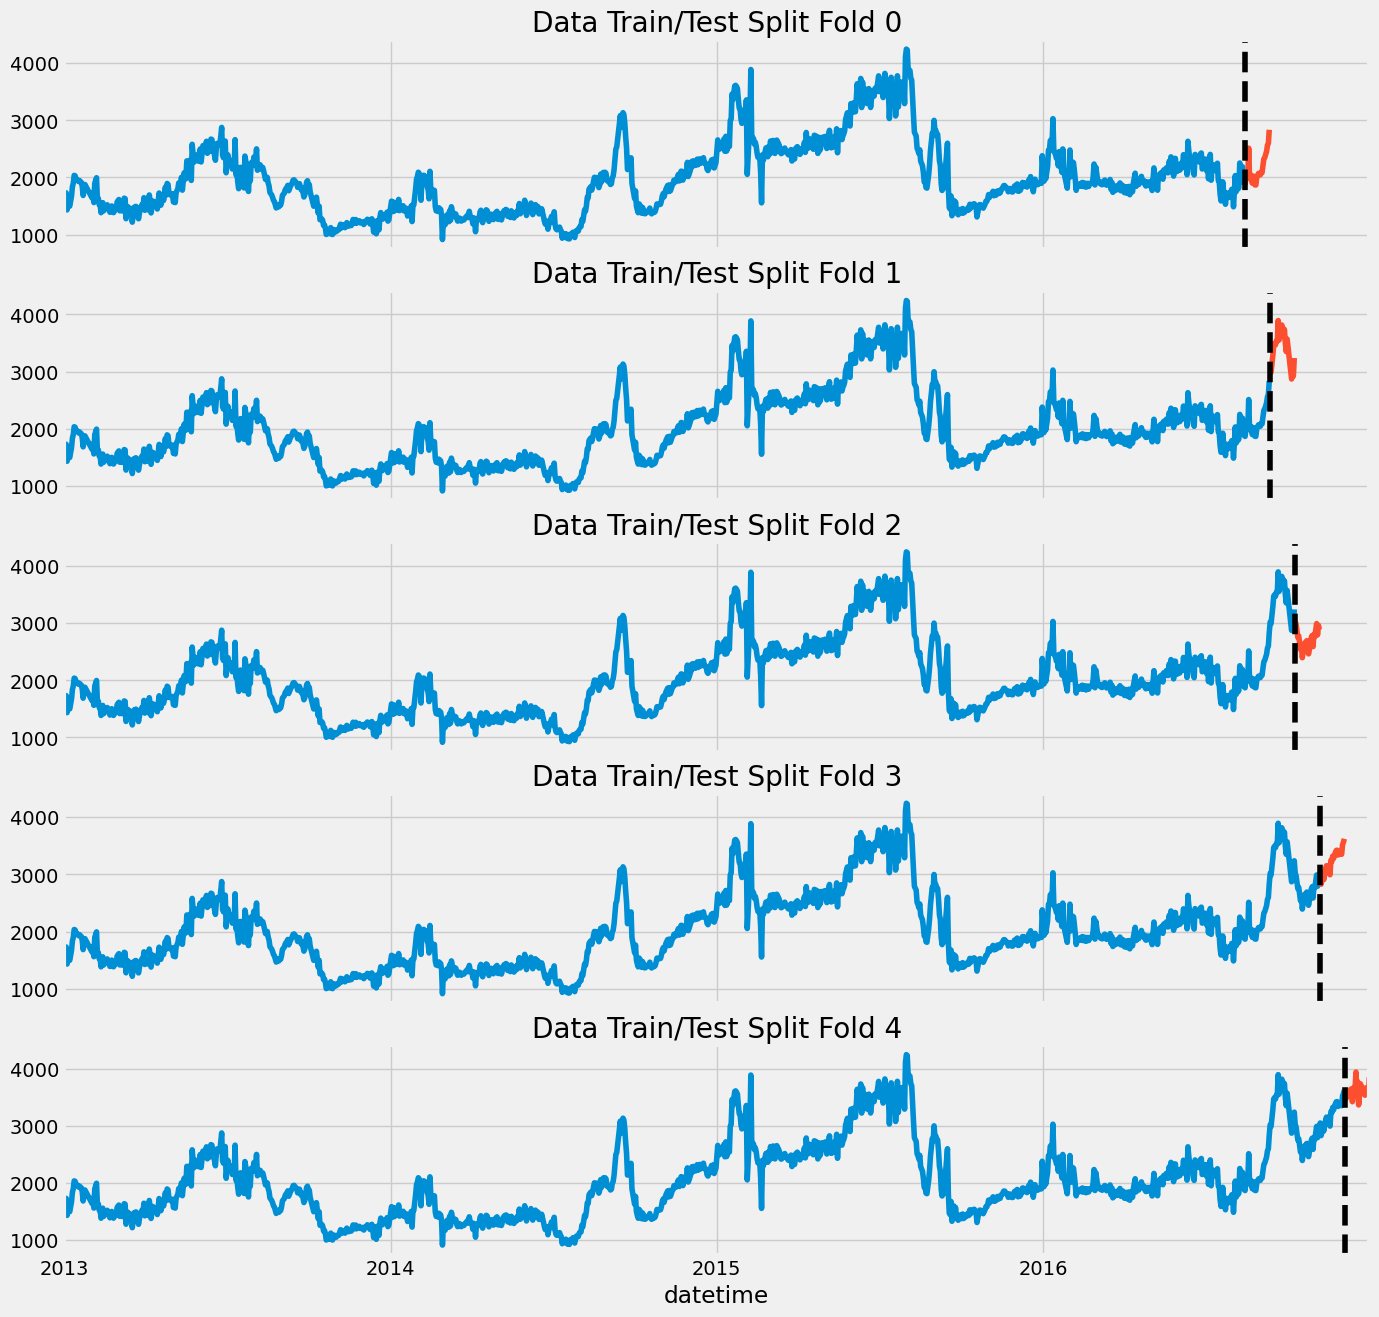

In [16]:

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=28, gap=0)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['해당일자_전체평균가격(원)'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['해당일자_전체평균가격(원)'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [17]:
@jit
def make_Tensor(array):
    return tf.convert_to_tensor(array, dtype=tf.float32)

@jit
def astype_data(data):
    df = data.astype(np.float32)
    return make_Tensor(df)

In [18]:
@jit
def x_time_window(df, t, t_sep):
    seq_len = t
    seqence_length = seq_len + t_sep

    result = []
    for index in range(len(df) - seqence_length):
        result.append(df[index: index + seqence_length].values)

    return np.array(result)

@jit
def y_time_window(df, t, t_sep):
    seq_len = t
    seqence_length = seq_len + t_sep

    result = []
    for index in range(14, len(df) - seqence_length):
        result.append(df[index: index + seqence_length].values - df.iloc[index-1])

    return np.array(result)

In [28]:
scalers = {}
# scale_columns = [c for c in df_train.columns if c not in ['datadate', 'cos_time']]

FEATURES = ['단가(원)', '거래량', '해당일자_전체거래물량(kg)',
    '일자별_도매가격_평균(원)', 'cos_time', '주산지_평균온도', '주산지_강수량']

TARGET = '해당일자_전체평균가격(원)'

for i in tqdm(train_list):
    df_number = i.split("_")[-1].split(".")[0]
    df_train = pd.read_csv(i)
    df_train = feature_select(df_train)
    df_train = feature_na(df_train)
    
    x = df_train[[c for c in df_train.columns if c != TARGET]]
    y = df_train[TARGET]
    
    scaler = RobustScaler()
    x = pd.DataFrame(scaler.fit_transform(x))
    scalers[df_number] = scaler

    data_x = x_time_window(x, 13, 1)
    data_y = y_time_window(y, 27, 1)

    # # y의 길이와 같은 길이로 설정
    xdata = data_x[:len(data_y)]
    ydata = data_y

    X_train, X_val, y_train, y_val = train_test_split(xdata, ydata, test_size=0.2, shuffle=False, random_state=119)

    model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                            n_estimators=1000,
                            early_stopping_rounds=50,
                            objective='reg:squarederror',
                            max_depth=3,
                            learning_rate=0.01)

    model.fit(X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
    )
    
    if os.path.exists(f'./model') == False:
        os.mkdir(f'./model')

    # 모델 저장
    model.save_model(f'./model/xgb-{df_number}.h5')

  0%|          | 0/37 [00:00<?, ?it/s]

(1461, 7)
(1461,)

(1447, 14, 7)
(1419, 28)

(1135, 14, 7)
(284, 14, 7)
(1135, 28)
(284, 28)


In [20]:
zero_csv = [0 for i in range(14)]  # 시점이 비어있는 데이터 0으로 채우기 위한 변수

for i in tqdm(range(10)):
    test_list = glob(f'./aT_data/data/test/set_{i}/*.csv')
    for idx,j in enumerate(test_list):
        df_test = pd.read_csv(j)
        if len(df_test) == 0:
            df_test[0] = zero_csv


        df_test = feature_select(df_test)
        df_test = feature_na(df_test)
        file_number = j.split('test_')[1].split('.')[0]
        # 사용할 열 선택 및 index 설정

        FFEATURES = ['단가(원)', '거래량', '해당일자_전체거래물량(kg)',
        '일자별_도매가격_평균(원)', 'cos_time', '주산지_평균온도', '주산지_강수량']

        TARGET = '해당일자_전체평균가격(원)'

        X_test = df_test[FEATURES]
        y_test = df_test[TARGET]

        # X_test_scaled = scalers[file_number].transform(X_test)

        # # x_test  생성
        # df_test = astype_data(df.values.reshape(1, df.values.shape[0], df.values.shape[1]))

        # model test
        if os.path.exists(f'./model_output/{test_num}') == False:
            os.mkdir(f'./model_output/{test_num}')

        if os.path.exists(f'./model_output/{test_num}/set_{i}') == False:
            os.mkdir(f'./model_output/{test_num}/set_{i}')

        # 해당하는 모델 불러오기
        model = xgb.XGBRegressor()
        model.load_model(f'./model/xgb-{file_number}.h5')
        pred = model.predict(X_test)

        # 결과 저장
        save_df = pd.DataFrame(pred)
        save_df.to_csv(f'./model_output/{test_num}/set_{i}/predict_{file_number}.csv', index=False)

100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


In [21]:
for k in tqdm(range(10)):
  globals()[f'set_df_{k}'] = pd.DataFrame()
  answer_df_list = glob(f'./model_output/{test_num}/set_{k}/*.csv') # 예측한 결과 불러오기
  pum_list = glob(f'.aT_data/aT_test_raw/sep_{k}/*.csv') # 기존 test input 불러오기
  pummok = [a for a in pum_list if 'pummok' in a.split('/')[-1]]

  for i in answer_df_list:
    df = pd.read_csv(i)
    number = i.split('_')[-1].split('.')[0]

    base_number = 0
    for p in pummok:
      if number == p.split('_')[-1].split('.')[0]:
        pum_df = pd.read_csv(p)

        if len(pum_df) != 0:
           base_number = pum_df.iloc[len(pum_df)-1]['해당일자_전체평균가격(원)']  # 기존 각 sep 마다 test input의 마지막 target 값 가져오기 (변동률 계산을 위해)
        else:
          base_number = np.nan

    globals()[f'set_df_{k}'][f'품목{number}']  = [base_number] + list(df[df.columns[-1]].values) # 각 품목당 순서를 t, t+1 ... t+28 로 변경

  globals()[f'set_df_{k}'] = globals()[f'set_df_{k}'][[f'품목{col}' for col in range(37)]] # 열 순서를 품목0 ~ 품목36 으로 변경

100%|██████████| 10/10 [00:00<00:00, 50.46it/s]


In [22]:
set_df_0

,품목0,품목1,품목2,품목3,품목4,품목5,품목6,품목7,품목8,품목9,...,품목27,품목28,품목29,품목30,품목31,품목32,품목33,품목34,품목35,품목36
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,0.00000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,19175.0080,1197.6151,2623.8467,3215.0520,3749.9504,4742.2450,2708.9631,2905.5833,4009.1920,1051.8217,...,10865.391,552.38030,833.47266,1204.9078,3251.4045,5514.9920,5113.0520,4044.0990,3157.7996,2261.2527
2,18417.1820,1197.6151,2623.8467,3215.0520,3761.6090,4742.2450,2708.9631,2902.9893,4009.1920,1051.8217,...,10865.391,552.38030,833.47266,1204.9078,3251.4045,5475.5770,5123.0923,4044.0990,3157.7996,2293.1138
3,6824.9263,1175.4324,2655.3810,3106.9897,3475.5815,4923.4897,2748.5100,2654.9216,4047.4530,1042.4612,...,10982.616,558.22930,833.96875,1214.0836,3182.4353,5185.3184,5065.3760,4620.2905,2322.4578,2417.7573
4,6846.3184,1140.0848,2623.2593,3060.4856,3467.2878,5137.4014,2748.5100,2355.2695,4079.1616,1042.4612,...,10092.329,558.65344,834.77670,1281.0088,3097.2966,4929.0376,5072.4272,4439.8857,2215.1719,2598.5754
5,7311.3257,1140.0848,2654.0469,3062.3030,3597.5366,5688.7120,2748.5100,2687.1255,4254.6850,1039.0474,...,11600.689,612.02490,887.46466,1259.1967,3155.4438,4941.6396,5074.7900,4694.1840,2190.0627,2388.3064
6,6606.6616,1156.8582,2663.1665,3060.4856,3450.0176,5168.8460,2708.9631,2592.0703,4416.3430,1042.8597,...,11765.160,646.41000,853.92820,1244.0889,4140.7560,5009.0300,5081.0810,4914.9507,2158.0427,2166.0461
7,6976.8003,1189.0897,2739.7004,3060.4856,3631.1165,5202.0337,2708.9631,2689.0024,4111.4106,1061.1344,...,11519.052,587.50980,853.92820,1244.0889,3629.1519,5004.8770,5215.6157,5354.3350,2371.7780,1922.1499
8,5491.9950,1399.3485,2780.7166,3126.3700,3784.0422,5227.0825,2708.9631,2571.9575,4322.9946,1061.1344,...,10143.358,550.67260,856.52480,1257.1776,3131.7770,5169.6875,5108.1000,5159.9243,2355.5127,2034.7593
9,9179.1900,1357.9460,2713.2312,3124.9263,3668.0408,5448.0960,2708.9631,2574.9960,4018.9450,1057.7206,...,10884.774,545.82950,878.92990,1257.1776,3131.7770,5169.6875,5106.0240,4564.5327,2247.4114,2009.5656


In [23]:
date = [f'd+{i}' for i in range(1,15)] + ['d+22 ~ 28 평균']

for k in range(10):
  globals()[f'answer_df_{k}'] = pd.DataFrame()
  for c in globals()[f'set_df_{k}'].columns:
    base_d = globals()[f'set_df_{k}'][c][0] # 변동률 기준 t 값
    ans_1_14 = []
    for i in range(14):
      ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1])/base_d)
    
    # ans_22_28 = (globals()[f'set_df_{k}'][c][22:29].mean() - base_d)/base_d # t+22 ~ t+28은 np.mean(t+22 ~ t+28) - t / t
    ans_22_28 = (globals()[f'set_df_{k}'][c][22:29].mean())/base_d
    globals()[f'answer_df_{k}'][f'{c} 변동률'] = ans_1_14 + [ans_22_28]
  
  globals()[f'answer_df_{k}']['Set'] = k # set 번호 설정
  globals()[f'answer_df_{k}']['일자'] = date # 일자 설정

/var/folders/8t/p9vrbnhn7xj3s_2zmct430yw0000gn/T/ipykernel_31823/1238775946.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1])/base_d)
/var/folders/8t/p9vrbnhn7xj3s_2zmct430yw0000gn/T/ipykernel_31823/1238775946.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1])/base_d)
/var/folders/8t/p9vrbnhn7xj3s_2zmct430yw0000gn/T/ipykernel_31823/1238775946.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1])/base_d)
/var/folders/8t/p9vrbnhn7xj3s_2zmct430yw0000gn/T/ipykernel_31823/1238775946.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1])/base_d)
/var/folders/8t/p9vrbnhn7xj3s_2zmct430yw0000gn/T/ipykernel_31823/1238775946.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  ans_1_14.append((gl